# Intro to Models

In this lecture we will learn about **modeling** data for the first time. After this lesson, you should know what we generally mean by a "model", what linear regression is and how to interpret the output.
But first we need to introduce a new data type: *categorical variables*.

    
1. [Categorical variables](#Categorical-variables)
2. [Models](#Models)
   - [Tables as models](#Tables-as-models)
   - [Modeling Missing Values](#Modeling-Missing-Values)
   - [Linear Regression](#Linear-Regression)


Online Resources:

[Chapter 7.5](https://wesmckinney.com/book/data-cleaning.html#pandas-categorical) of our textbook introduces categorical variables.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
#!pip install gapminder
from gapminder import gapminder

In [ ]:
gapminder.head()

,country,continent,year,lifeExp,pop,gdpPercap
0,Afghanistan,Asia,1952,28.801,8425333,779.445314
1,Afghanistan,Asia,1957,30.332,9240934,820.853030
2,Afghanistan,Asia,1962,31.997,10267083,853.100710
3,Afghanistan,Asia,1967,34.020,11537966,836.197138
4,Afghanistan,Asia,1972,36.088,13079460,739.981106


## Categorical variables

As a motivation, take another look at the gapminder data which contains variables of a **mixed type**: numeric columns along with string type columns which contain repeated instances of a smaller set of distinct or **discrete** values which 

1. are not numeric (but could be represented as numbers)
2. cannot really be ordered
3. typically take on a finite set of values, or *categories*.

We refer to these data types as **categorical**.

We have already seen functions like `unique` and `value_counts`, which enable us to extract the distinct values from an array and compute their frequencies.

Boxplots and grouping operations typically use a categorical variable to compute summaries of a numerical variables for each category separately, e.g.

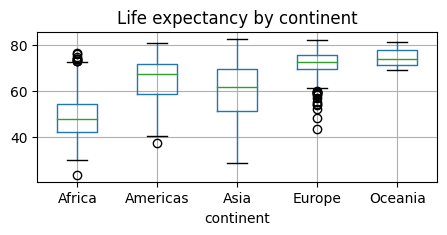

In [ ]:
gapminder.boxplot(column = "lifeExp", by="continent",figsize=(5, 2));
plt.title('Life expectancy by continent')
# Remove the default suptitle
plt.suptitle("");

pandas has a special `Categorical` extension type for holding data that uses the integer-based categorical representation or encoding. This is a popular data compression technique for data with many occurrences of similar values and can provide significantly faster performance with lower memory use, especially for string data.

In [ ]:
gapminder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    1704 non-null   object 
 1   continent  1704 non-null   object 
 2   year       1704 non-null   int64  
 3   lifeExp    1704 non-null   float64
 4   pop        1704 non-null   int64  
 5   gdpPercap  1704 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 80.0+ KB


In [ ]:
gapminder['country'] = gapminder['country'].astype('category')
gapminder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   country    1704 non-null   category
 1   continent  1704 non-null   object  
 2   year       1704 non-null   int64   
 3   lifeExp    1704 non-null   float64 
 4   pop        1704 non-null   int64   
 5   gdpPercap  1704 non-null   float64 
dtypes: category(1), float64(2), int64(2), object(1)
memory usage: 75.2+ KB


We will come back to the usefulness of this later.



## Tables as models

For now let us look at our first "model":

In [28]:
titanic = sns.load_dataset('titanic')
titanic["class3"] = (titanic["pclass"]==3)
titanic["male"] = (titanic["sex"]=="male")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,class3,male
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,True,True
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,False,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,True,False
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,False,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,True,True


In [16]:
vals1, cts1 = np.unique(titanic["class3"], return_counts=True)
print(cts1)
print(vals1)

[400 491]
[False  True]


In [ ]:
print("The mean survival on the Titanic was", np.mean(titanic.survived))

The mean survival on the Titanic was 0.3838383838383838


In [6]:
ConTbl = pd.crosstab(titanic["sex"], titanic["survived"])
ConTbl

survived,0,1
sex,,
female,81,233
male,468,109


What are the estimated survival probabilities?

In [ ]:
#the good old groupby way:
bySex = titanic.groupby("sex").survived
bySex.mean()

sex
female    0.742038
male      0.188908
Name: survived, dtype: float64

In [17]:
p3D = pd.crosstab([titanic["sex"], titanic["class3"]], titanic["survived"])
p3D

survived         0    1
sex    class3          
female False     9  161
       True     72   72
male   False   168   62
       True    300   47

What are the estimated survival probabilities?

In [18]:
#the good old groupby way:
bySex = titanic.groupby(["sex", "class3"]).survived
bySex.mean()

sex     class3
female  False     0.947059
        True      0.500000
male    False     0.269565
        True      0.135447
Name: survived, dtype: float64

The above table can be looked at as a **model**, which is defined as a function which takes *inputs* **x** and "spits out" a *prediction*: 

$y = f(\mathbf{x})$

In our case, the inputs are $x_1=\text{sex}$, $x_2=\text{class3}$, and the output is the estimated survival probability!

It is evident that we could keep adding more *input* variables and make finer and finer grained predictions.

### Linear Models

In [29]:
lsFit = smf.ols('survived ~ sex:class3-1', titanic).fit()
lsFit.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
sex[female]:class3[False],0.9471,0.029,32.200,0.000,0.889,1.005
sex[male]:class3[False],0.2696,0.025,10.660,0.000,0.220,0.319
sex[female]:class3[True],0.5000,0.032,15.646,0.000,0.437,0.563
sex[male]:class3[True],0.1354,0.021,6.579,0.000,0.095,0.176


### Modeling Missing Values

We have already seen how to detect and how to replace missing values.
But the latter -until now- was rather crude: we often replaced all values with a "global" average.

Clearly, we can do better than replacing all missing entries in the *survived* column with the average $0.38$. 

In [31]:
rng = default_rng()

missingRows = rng.integers(0,890,20)
print(missingRows)
#introduce missing values
titanic.iloc[missingRows,0] = np.nan
np.sum(titanic.survived.isna())

[864 299 857 182 808 817 802 295 255 644   1 685 452 463 303 551 517 502
 495 412]


20

In [32]:
predSurv = lsFit.predict()
print( len(predSurv))
predSurv[titanic.survived.isna()]

891


array([0.94705882, 0.13544669, 0.5       , 0.26956522, 0.94705882,
       0.94705882, 0.94705882, 0.26956522, 0.26956522, 0.13544669,
       0.5       , 0.13544669, 0.26956522, 0.5       , 0.26956522,
       0.26956522, 0.26956522, 0.26956522, 0.26956522, 0.26956522])

#### From categorical to numerical relations

In [ ]:
url = "https://drive.google.com/file/d/1UbZy5Ecknpl1GXZBkbhJ_K6GJcIA2Plq/view?usp=share_link" 
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
auto = pd.read_csv(url)
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,Manufacturer
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,chevrolet
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,buick
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,plymouth
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,amc
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,ford


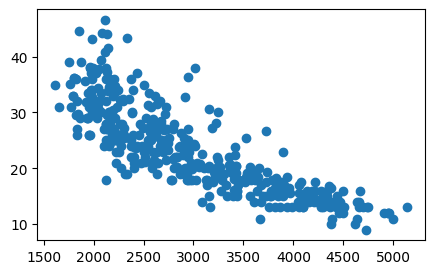

In [ ]:
plt.figure(figsize=(5,3))
plt.scatter(x=auto["weight"], y=auto["mpg"]);

## Linear Regression

We can roughly estimate, i.e. "model" this relationship with a straight line:

$$
y = \beta_0 + \beta_1 x
$$

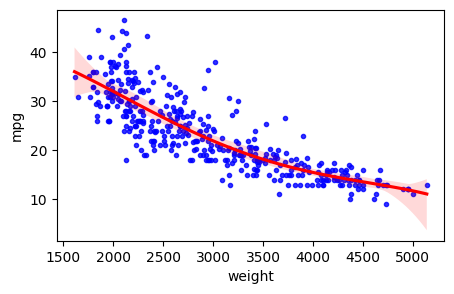

In [ ]:
plt.figure(figsize=(5,3))
tmp=sns.regplot(x=auto["weight"], y=auto["mpg"], order=1, ci=95, 
                scatter_kws={'color':'b', 's':9}, line_kws={'color':'r'})

Remind yourself of the definition of the slope of a straight line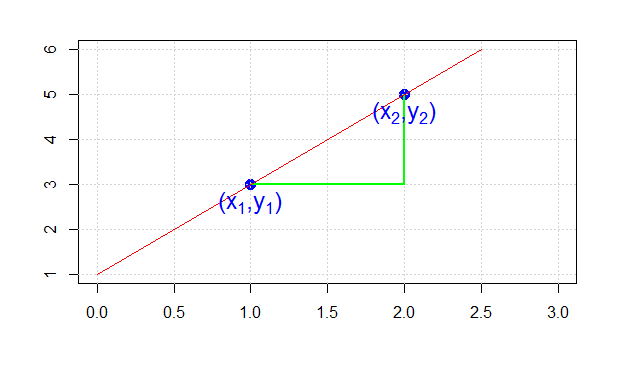

$$
\beta_1 = \frac{\Delta y}{\Delta x} =  \frac{y_2-y_1}{x_2-x_1}
$$

In [ ]:
est = smf.ols('mpg ~ weight', auto).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,46.2165,0.799,57.867,0.000,44.646,47.787
weight,-0.0076,0.000,-29.645,0.000,-0.008,-0.007


In [ ]:
np.corrcoef(auto["weight"], auto["mpg"])

array([[ 1.        , -0.83224421],
       [-0.83224421,  1.        ]])

--------------------------


Further Reading:

- []()